# VGG

In [12]:
pip install scikit-image

     ---------------------------------------- 0.0/12.7 MB ? eta -:--:--
     -- ------------------------------------- 0.8/12.7 MB 16.3 MB/s eta 0:00:01
     ------------ --------------------------- 4.0/12.7 MB 42.6 MB/s eta 0:00:01
     --------------------------- ------------ 8.7/12.7 MB 61.4 MB/s eta 0:00:01
     ---------------------------------- ---- 11.3/12.7 MB 73.1 MB/s eta 0:00:01
     --------------------------------------  12.7/12.7 MB 72.6 MB/s eta 0:00:01
     --------------------------------------- 12.7/12.7 MB 59.5 MB/s eta 0:00:00
     ---------------------------------------- 0.0/225.5 kB ? eta -:--:--
     ---------------------------------------- 225.5/225.5 kB ? eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


c:\Users\Kaan\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Kaan\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MSE correlation with MOS for top 10% PE: -0.588968838716223
SSIM correlation with MOS for top 10% PE: 0.5575297445290633


C:\Users\Kaan\AppData\Local\Temp\ipykernel_9056\3032128147.py:210: OptimizeWarning: Covariance of the parameters could not be estimated
  log_params_mse, _ = curve_fit(logistic, mse_scores_top, top_mos_values, p0=[50, 0.1, 0], maxfev=2000)
C:\Users\Kaan\AppData\Local\Temp\ipykernel_9056\3032128147.py:206: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k * (x - x0)))
C:\Users\Kaan\AppData\Local\Temp\ipykernel_9056\3032128147.py:215: OptimizeWarning: Covariance of the parameters could not be estimated
  log_params_ssim, _ = curve_fit(logistic, ssim_scores_top, top_mos_values, p0=[50, 0.1, 0], maxfev=2000)


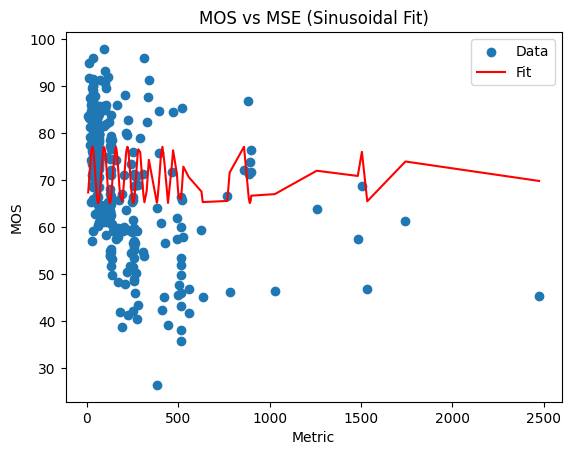

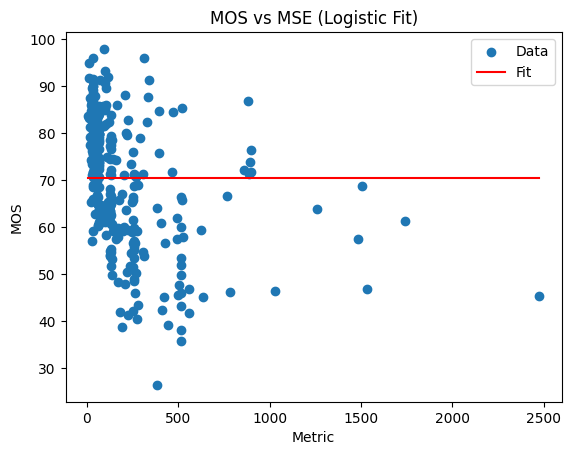

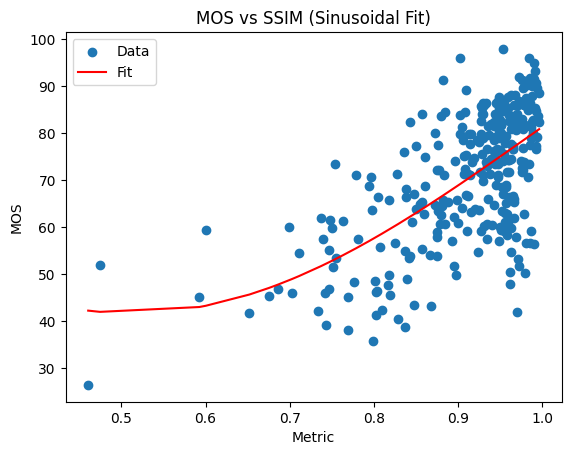

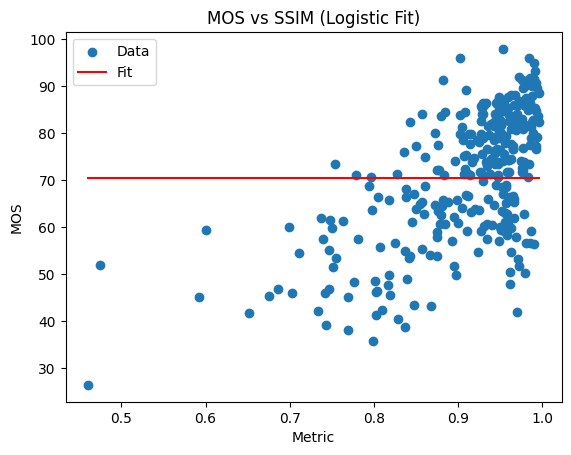

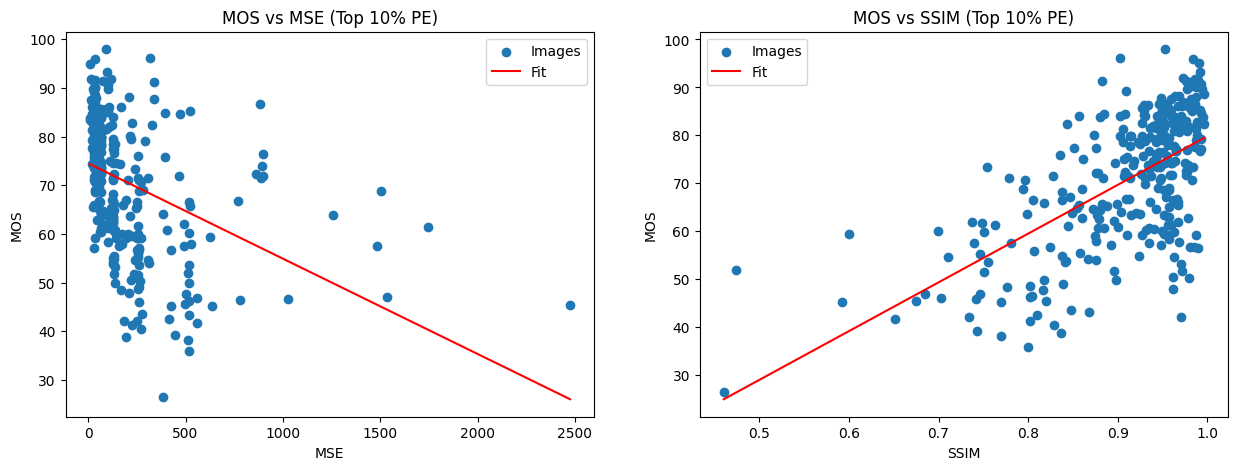

In [30]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import vgg16
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import mean_squared_error, structural_similarity as ssim
from scipy.ndimage import zoom
from scipy.stats import spearmanr
from scipy.optimize import curve_fit
import pickle


image_directory = r"C:\Users\Kaan\Downloads\distorted_images"
mos_file_path = r"C:\Users\Kaan\Downloads\mos.csv"
reference_image_directory = r"C:\Users\Kaan\Downloads\reference_images"
checkpoint_path = r"C:\Users\Kaan\Downloads\checkpoint2.pkl"

mos_df = pd.read_csv(mos_file_path)
image_files = mos_df['image_id'].tolist()
mos_values = mos_df['mean'].tolist()

# Scale DMOS values to match the paper's range
mos_values = [(mos / 7) * 100 for mos in mos_values]

model = vgg16(pretrained=True).features
model.eval()

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = preprocess(image).unsqueeze(0)
    return image

def get_feature_maps(image, model):
    x = image
    feature_maps = []
    for layer in model:
        x = layer(x)
        feature_maps.append(x)
    return feature_maps

def compute_csf(f):
    return 2.6 * (0.0192 + 0.114 * f) * np.exp(- (0.114 * f) ** 1.1)

def generate_sinusoidal_grating(size, frequency, orientation=0):
    x = np.linspace(0, 2 * np.pi * frequency, size)
    y = np.linspace(0, 2 * np.pi * frequency, size)
    X, Y = np.meshgrid(x, y)
    grating = np.sin(X * np.cos(orientation) + Y * np.sin(orientation))
    return grating

def resize_grating(grating, target_shape):
    zoom_factors = [target_shape[0] / grating.shape[0], target_shape[1] / grating.shape[1]]
    resized_grating = zoom(grating, zoom_factors)
    return resized_grating

def compute_frequency_selectivity(feature_maps):
    frequency_selectivity = []
    csf_frequencies = np.linspace(6, 8, 20)
    
    for feature_map in feature_maps:
        target_shape = feature_map.shape[-2:]
        fm_np = feature_map.squeeze(0).detach().numpy()
        freq_responses = []
        
        for f in csf_frequencies:
            grating = generate_sinusoidal_grating(224, f)
            grating = resize_grating(grating, target_shape)
            response = np.mean(np.abs(fm_np * grating))
            freq_responses.append(response)
        
        freq_responses = np.array(freq_responses)
        csf_weights = compute_csf(csf_frequencies)  
        
        mu1 = np.sum(csf_weights * np.abs(np.gradient(freq_responses)))  
        frequency_selectivity.append(mu1)
    
    return frequency_selectivity

def compute_orientation_selectivity(feature_maps):
    orientation_selectivity = []
    fixed_frequency = 8  
    
    for feature_map in feature_maps:
        target_shape = feature_map.shape[-2:]  
        fm_np = feature_map.squeeze(0).detach().numpy()
        orient_responses = []
        
        for theta in np.linspace(-np.pi / 2, np.pi / 2, 18): 
            grating = generate_sinusoidal_grating(224, fixed_frequency, theta)
            grating = resize_grating(grating, target_shape)
            response = np.mean(np.abs(fm_np * grating))
            orient_responses.append(response)
        
        orient_responses = np.array(orient_responses)
        a_hat = np.max(orient_responses)
        mu2 = np.sum((orient_responses - a_hat) ** 2)
        orientation_selectivity.append(mu2)
    
    return orientation_selectivity

def compute_perceptual_efficacy(frequency_selectivity, orientation_selectivity):
    mu1_normalized = frequency_selectivity / np.max(frequency_selectivity)
    mu2_normalized = orientation_selectivity / np.max(orientation_selectivity)
    PE = (mu1_normalized * mu2_normalized) / (np.sum(mu1_normalized) * np.sum(mu2_normalized))
    return PE

# Load or initialize data
all_frequency_selectivity = []
all_orientation_selectivity = []
all_pe_scores = []

start_idx = 0
if os.path.exists(checkpoint_path):
    with open(checkpoint_path, 'rb') as f:
        checkpoint = pickle.load(f)
        start_idx = checkpoint['start_idx']
        all_frequency_selectivity = checkpoint['all_frequency_selectivity']
        all_orientation_selectivity = checkpoint['all_orientation_selectivity']
        all_pe_scores = checkpoint['all_pe_scores']

for idx, image_file in enumerate(image_files[start_idx:], start=start_idx):
    image_path = os.path.join(image_directory, image_file)
    image = load_image(image_path)
    feature_maps = get_feature_maps(image, model)
    freq_sel = compute_frequency_selectivity(feature_maps)
    orient_sel = compute_orientation_selectivity(feature_maps)
    pe_scores = compute_perceptual_efficacy(freq_sel, orient_sel)
    
    all_frequency_selectivity.append(freq_sel)
    all_orientation_selectivity.append(orient_sel)
    all_pe_scores.append(pe_scores)
    
    if (idx + 1) % 10 == 0:
        with open(checkpoint_path, 'wb') as f:
            pickle.dump({
                'start_idx': idx + 1,
                'all_frequency_selectivity': all_frequency_selectivity,
                'all_orientation_selectivity': all_orientation_selectivity,
                'all_pe_scores': all_pe_scores,
            }, f)

average_pe_scores = [np.mean(pe) for pe in all_pe_scores]

# Order images by PE scores and select top 10%
ordered_indices = np.argsort(average_pe_scores)[::-1]  # Descending order
top_10_percent_indices = ordered_indices[:len(ordered_indices) // 20]

top_image_files = [image_files[idx] for idx in top_10_percent_indices]
top_mos_values = [mos_values[idx] for idx in top_10_percent_indices]

# Function to compute MSE
def compute_mse(image1, image2):
    image1_np = np.array(image1)
    image2_np = np.array(image2)
    return mean_squared_error(image1_np, image2_np)

# Function to compute SSIM
def compute_ssim(image1, image2):
    image1_np = np.array(image1)
    image2_np = np.array(image2)
    # Use a fixed win_size of 3
    win_size = 3
    return ssim(image1_np, image2_np, multichannel=True, win_size=win_size)

# Calculate MSE and SSIM for top 10% images
mse_scores_top = []
ssim_scores_top = []

for image_file in top_image_files:
    distorted_image_path = os.path.join(image_directory, image_file)
    distorted_image = Image.open(distorted_image_path).convert('RGB')
    
    # Get reference image based on distorted image name
    ref_image_key = image_file.split('_')[0]  # Keep only the first part before underscore
    ref_image_path = os.path.join(reference_image_directory, ref_image_key + '.bmp')
    
    if os.path.exists(ref_image_path):
        ref_image = Image.open(ref_image_path).convert('RGB')
        mse_scores_top.append(compute_mse(ref_image, distorted_image))
        ssim_scores_top.append(compute_ssim(ref_image, distorted_image))
    else:
        print(f'Reference image not found for {image_file}')

# Calculate correlation with MOS values
mse_correlation, _ = spearmanr(mse_scores_top, top_mos_values)
ssim_correlation, _ = spearmanr(ssim_scores_top, top_mos_values)

print(f'MSE correlation with MOS for top 10% PE: {mse_correlation}')
print(f'SSIM correlation with MOS for top 10% PE: {ssim_correlation}')

def sinusoidal(x, a, b, c, d):
    return a * np.sin(b * x + c) + d

def logistic(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

# Fit the models
sin_params_mse, _ = curve_fit(sinusoidal, mse_scores_top, top_mos_values, p0=[50, 0.1, 0, 50])
log_params_mse, _ = curve_fit(logistic, mse_scores_top, top_mos_values, p0=[50, 0.1, 0], maxfev=2000)



sin_params_ssim, _ = curve_fit(sinusoidal, ssim_scores_top, top_mos_values, p0=[50, 0.1, 0, 50])
log_params_ssim, _ = curve_fit(logistic, ssim_scores_top, top_mos_values, p0=[50, 0.1, 0], maxfev=2000)

def plot_with_curve(x_data, y_data, curve_params, curve_func, title):
    plt.scatter(x_data, y_data, label='Data')
    plt.plot(np.unique(x_data), curve_func(np.unique(x_data), *curve_params), color='red', label='Fit')
    plt.title(title)
    plt.xlabel('Metric')
    plt.ylabel('MOS')
    plt.legend()
    plt.show()

# Plot MOS vs MSE with fitted curves
plot_with_curve(mse_scores_top, top_mos_values, sin_params_mse, sinusoidal, 'MOS vs MSE (Sinusoidal Fit)')
plot_with_curve(mse_scores_top, top_mos_values, log_params_mse, logistic, 'MOS vs MSE (Logistic Fit)')

# Plot MOS vs SSIM with fitted curves
plot_with_curve(ssim_scores_top, top_mos_values, sin_params_ssim, sinusoidal, 'MOS vs SSIM (Sinusoidal Fit)')
plot_with_curve(ssim_scores_top, top_mos_values, log_params_ssim, logistic, 'MOS vs SSIM (Logistic Fit)')

def plot_results(mse_scores, ssim_scores, mos_values):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))



    ax1.scatter(mse_scores, mos_values, label='Images')
    ax1.plot(np.unique(mse_scores), np.poly1d(np.polyfit(mse_scores, mos_values, 1))(np.unique(mse_scores)), color='red', label='Fit')
    ax1.set_title('MOS vs MSE (Top 10% PE)')
    ax1.set_xlabel('MSE')
    ax1.set_ylabel('MOS')
    ax1.legend()

    ax2.scatter(ssim_scores, mos_values, label='Images')
    ax2.plot(np.unique(ssim_scores), np.poly1d(np.polyfit(ssim_scores, mos_values, 1))(np.unique(ssim_scores)), color='red', label='Fit')
    ax2.set_title('MOS vs SSIM (Top 10% PE)')
    ax2.set_xlabel('SSIM')
    ax2.set_ylabel('MOS')
    ax2.legend()

    plt.show()

plot_results(mse_scores_top, ssim_scores_top, top_mos_values)




c:\Users\Kaan\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Kaan\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Processing image 1 of 3000
Processing image 2 of 3000
Processing image 3 of 3000
Processing image 4 of 3000
Processing image 5 of 3000
Processing image 6 of 3000
Processing image 7 of 3000
Processing image 8 of 3000
Processing image 9 of 3000
Processing image 10 of 3000
Processing image 11 of 3000
Processing image 12 of 3000
Processing image 13 of 3000
Processing image 14 of 3000
Processing image 15 of 3000
Processing image 16 of 3000
Processing image 17 of 3000
Processing image 18 of 3000
Processing image 19 of 3000
Processing image 20 of 3000
Processing image 21 of 3000
Processing image 22 of 3000
Processing image 23 of 3000
Processing image 24 of 3000
Processing image 25 of 3000
Processing image 26 of 3000
Processing image 27 of 3000
Processing image 28 of 3000
Processing image 29 of 3000
Processing image 30 of 3000
Processing image 31 of 3000
Processing image 32 of 3000
Processing image 33 of 3000
Processing image 34 of 3000
Processing image 35 of 3000
Processing image 36 of 3000
P

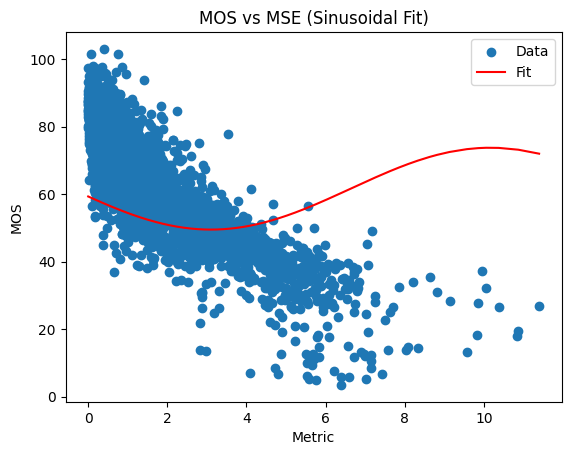

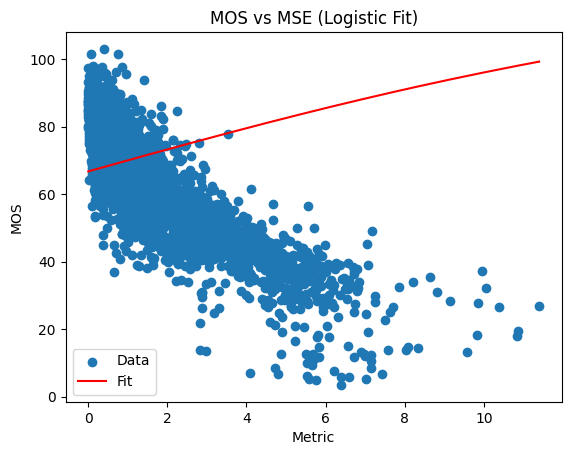

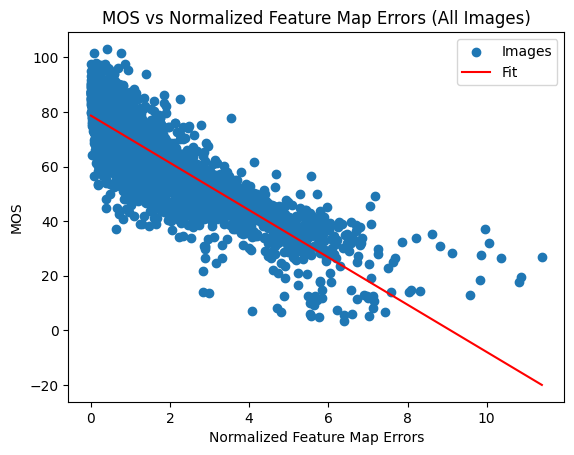

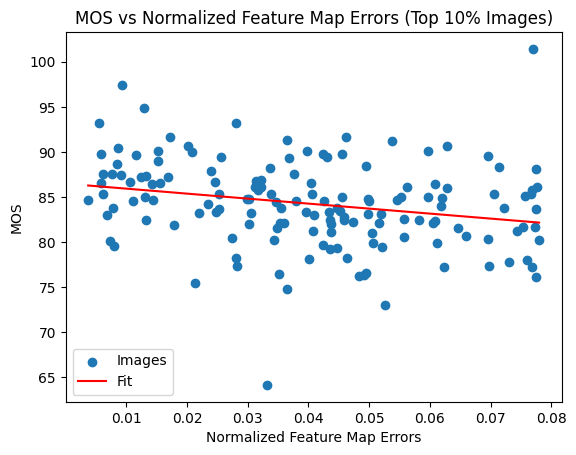

In [42]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import vgg16
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import mean_squared_error, structural_similarity as ssim
from scipy.ndimage import zoom
from scipy.stats import spearmanr
from scipy.optimize import curve_fit
import pickle


image_directory = r"C:\Users\Kaan\Downloads\distorted_images"
mos_file_path = r"C:\Users\Kaan\Downloads\mos.csv"
reference_image_directory = r"C:\Users\Kaan\Downloads\reference_images"
checkpoint_path = r"C:\Users\Kaan\Downloads\checkpoint_Vgg_image.pkl"

mos_df = pd.read_csv(mos_file_path)
image_files = mos_df['image_id'].tolist()
mos_values = mos_df['mean'].tolist()

mos_values = [(mos / 7) * 100 for mos in mos_values]

model = vgg16(pretrained=True).features
model.eval()

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = preprocess(image).unsqueeze(0)
    return image

def get_feature_maps(image, model):
    x = image
    feature_maps = []
    for layer in model:
        x = layer(x)
        feature_maps.append(x)
    return feature_maps

def compare_feature_maps_with_reference(distorted_image, reference_image, model,last=0):
    distorted_feature_maps = get_feature_maps(distorted_image, model)
    reference_feature_maps = get_feature_maps(reference_image, model)
    
    normalized_errors = []
    
    for idx, (distorted_map, reference_map) in enumerate(zip(distorted_feature_maps, reference_feature_maps)):
        difference = distorted_map - reference_map
        
        squared_error = torch.sum(difference ** 2)
        
        C_l, H_l, W_l = distorted_map.shape[1:]
        normalized_error = squared_error / (C_l * H_l * W_l)
        
        normalized_errors.append(normalized_error.item())
        if (last==1):

            plt.hist(distorted_map.detach().cpu().numpy().flatten(), bins=50, alpha=0.5, label=f'Layer {idx + 1}')
            plt.title(f'Histogram of Intermediate Layer {idx + 1}')
            plt.xlabel('Feature Map Values')
            plt.ylabel('Frequency')
            plt.legend()
            plt.show()
    
    return normalized_errors

all_normalized_errors = []

start_idx = 0
if os.path.exists(checkpoint_path):
    with open(checkpoint_path, 'rb') as f:
        checkpoint = pickle.load(f)
        start_idx = checkpoint['start_idx']
        all_normalized_errors = checkpoint['all_normalized_errors']

for idx, image_file in enumerate(image_files[start_idx:], start=start_idx):
    distorted_image_path = os.path.join(image_directory, image_file)
    distorted_image = load_image(distorted_image_path)
    
    ref_image_key = image_file.split('_')[0]  
    ref_image_path = os.path.join(reference_image_directory, ref_image_key + '.bmp')
    
    if os.path.exists(ref_image_path):
        reference_image = load_image(ref_image_path)
        if (idx==len(image_files)-1):
            last=1
        print(f'Processing image {idx + 1} of {len(image_files)}')
        normalized_errors = compare_feature_maps_with_reference(distorted_image, reference_image, model,last=0)
        all_normalized_errors.append(np.mean(normalized_errors))  
    
    if (idx + 1) % 10 == 0:
        with open(checkpoint_path, 'wb') as f:
            pickle.dump({
                'start_idx': idx + 1,
                'all_normalized_errors': all_normalized_errors,
            }, f)

ordered_indices = np.argsort(all_normalized_errors) 
top_10_percent_indices = ordered_indices[:len(ordered_indices) // 20]

top_image_files = [image_files[idx] for idx in top_10_percent_indices]
top_mos_values = [mos_values[idx] for idx in top_10_percent_indices]

normalized_error_correlation, _ = spearmanr(all_normalized_errors, mos_values)
print(f'Correlation of normalized feature map errors with MOS for all images: {normalized_error_correlation}')

normalized_error_correlation_top, _ = spearmanr([all_normalized_errors[idx] for idx in top_10_percent_indices], top_mos_values)
print(f'Correlation of normalized feature map errors with MOS for top 10% images: {normalized_error_correlation_top}')

def sinusoidal(x, a, b, c, d):
    return a * np.sin(b * x + c) + d

def logistic(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

# Fit the models
sin_params_mse, _ = curve_fit(sinusoidal, normalized_error_correlation, mos_values, p0=[50, 0.1, 0, 50])
log_params_mse, _ = curve_fit(logistic, normalized_error_correlation, mos_values, p0=[50, 0.1, 0], maxfev=2000)

def plot_with_curve(x_data, y_data, curve_params, curve_func, title):
    plt.scatter(x_data, y_data, label='Data')
    plt.plot(np.unique(x_data), curve_func(np.unique(x_data), *curve_params), color='red', label='Fit')
    plt.title(title)
    plt.xlabel('Metric')
    plt.ylabel('MOS')
    plt.legend()
    plt.show()

# Plot MOS vs MSE with fitted curves
plot_with_curve(all_normalized_errors, mos_values, sin_params_mse, sinusoidal, 'MOS vs MSE (Sinusoidal Fit)')
plot_with_curve(all_normalized_errors, mos_values, log_params_mse, logistic, 'MOS vs MSE (Logistic Fit)')

def plot_normalized_errors_vs_mos(normalized_errors, mos_values, title):
    plt.scatter(normalized_errors, mos_values, label='Images')
    plt.plot(np.unique(normalized_errors), np.poly1d(np.polyfit(normalized_errors, mos_values, 1))(np.unique(normalized_errors)), color='red', label='Fit')
    plt.title(title)
    plt.xlabel('Normalized Feature Map Errors')
    plt.ylabel('MOS')
    plt.legend()
    plt.show()

plot_normalized_errors_vs_mos(all_normalized_errors, mos_values, 'MOS vs Normalized Feature Map Errors (All Images)')

plot_normalized_errors_vs_mos([all_normalized_errors[idx] for idx in top_10_percent_indices], top_mos_values, 'MOS vs Normalized Feature Map Errors (Top 10% Images)')


c:\Users\Kaan\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Kaan\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Correlation of normalized feature map errors with MOS for all images: -0.8536713426564616


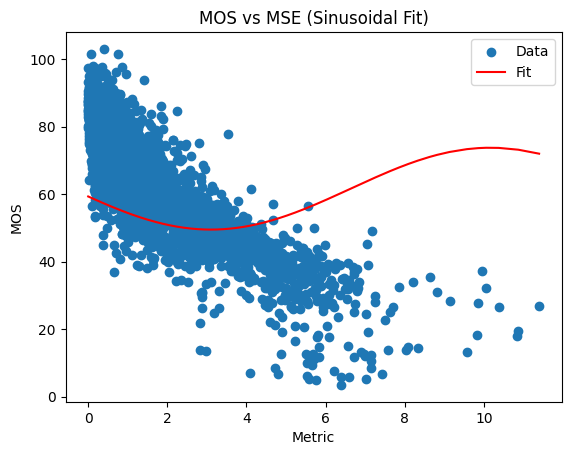

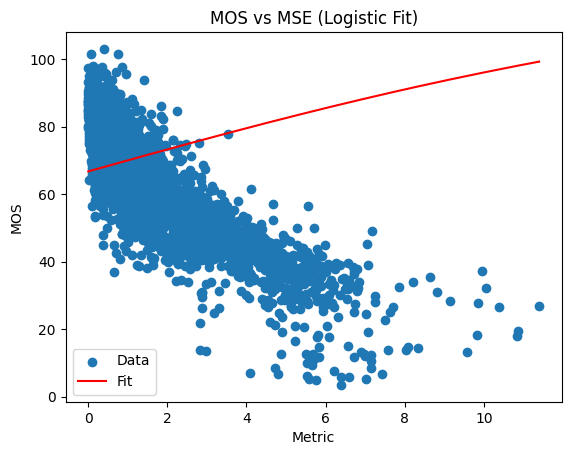

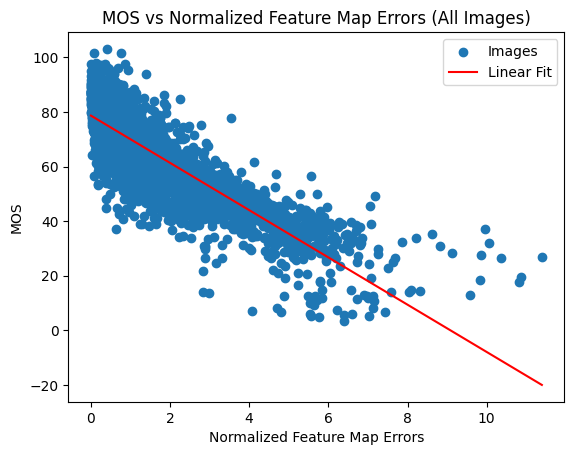

In [52]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import vgg16
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy.optimize import curve_fit
import pickle

image_directory = r"C:\Users\Kaan\Downloads\distorted_images"
mos_file_path = r"C:\Users\Kaan\Downloads\mos.csv"
reference_image_directory = r"C:\Users\Kaan\Downloads\reference_images"
checkpoint_path = r"C:\Users\Kaan\Downloads\checkpoint_Vgg_image_poly.pkl"

mos_df = pd.read_csv(mos_file_path)
image_files = mos_df['image_id'].tolist()
mos_values = mos_df['mean'].tolist()

mos_values = [(mos / 7) * 100 for mos in mos_values]

model = vgg16(pretrained=True).features
model.eval()

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = preprocess(image).unsqueeze(0)
    return image

def get_feature_maps(image, model):
    x = image
    feature_maps = []
    for layer in model:
        x = layer(x)
        feature_maps.append(x)
    return feature_maps

def compare_feature_maps_with_reference(distorted_image, reference_image, model):
    distorted_feature_maps = get_feature_maps(distorted_image, model)
    reference_feature_maps = get_feature_maps(reference_image, model)
    
    normalized_errors = []
    
    for distorted_map, reference_map in zip(distorted_feature_maps, reference_feature_maps):
        difference = distorted_map - reference_map
        squared_error = torch.sum(difference ** 2)
        
        C_l, H_l, W_l = distorted_map.shape[1:]
        normalized_error = squared_error / (C_l * H_l * W_l)
        
        normalized_errors.append(normalized_error.item())
    
    return normalized_errors

all_normalized_errors = []
start_idx = 0

if os.path.exists(checkpoint_path):
    with open(checkpoint_path, 'rb') as f:
        checkpoint = pickle.load(f)
        start_idx = checkpoint['start_idx']
        all_normalized_errors = checkpoint['all_normalized_errors']

for idx, image_file in enumerate(image_files[start_idx:], start=start_idx):
    distorted_image_path = os.path.join(image_directory, image_file)
    distorted_image = load_image(distorted_image_path)
    
    ref_image_key = image_file.split('_')[0]  
    ref_image_path = os.path.join(reference_image_directory, ref_image_key + '.bmp')
    
    if os.path.exists(ref_image_path):
        reference_image = load_image(ref_image_path)
        print(f'Processing image {idx + 1} of {len(image_files)}')
        print(f"Reference image name : {ref_image_key}, compared image name : {image_file}")
        normalized_errors = compare_feature_maps_with_reference(distorted_image, reference_image, model)
        print(f"Error for image number : {idx+1} \n Error :{np.mean(normalized_errors)}")
        all_normalized_errors.append(np.mean(normalized_errors))  
    
    if (idx + 1) % 10 == 0:
        with open(checkpoint_path, 'wb') as f:
            pickle.dump({
                'start_idx': idx + 1,
                'all_normalized_errors': all_normalized_errors,
            }, f)

normalized_error_correlation, _ = spearmanr(all_normalized_errors, mos_values)
print(f'Correlation of normalized feature map errors with MOS for all images: {normalized_error_correlation}')

def sinusoidal(x, a, b, c, d):
    return a * np.sin(b * x + c) + d

def logistic(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

sin_params_mse, _ = curve_fit(sinusoidal, normalized_error_correlation, mos_values, p0=[50, 0.1, 0, 50])
log_params_mse, _ = curve_fit(logistic, normalized_error_correlation, mos_values, p0=[50, 0.1, 0], maxfev=2000)

def plot_with_curve(x_data, y_data, curve_params, curve_func, title):
    plt.scatter(x_data, y_data, label='Data')
    plt.plot(np.unique(x_data), curve_func(np.unique(x_data), *curve_params), color='red', label='Fit')
    plt.title(title)
    plt.xlabel('Metric')
    plt.ylabel('MOS')
    plt.legend()
    plt.show()

plot_with_curve(all_normalized_errors, mos_values, sin_params_mse, sinusoidal, 'MOS vs MSE (Sinusoidal Fit)')
plot_with_curve(all_normalized_errors, mos_values, log_params_mse, logistic, 'MOS vs MSE (Logistic Fit)')

def plot_normalized_errors_vs_mos(normalized_errors, mos_values, title):
    plt.scatter(normalized_errors, mos_values, label='Images')
    plt.plot(np.unique(normalized_errors), np.poly1d(np.polyfit(normalized_errors, mos_values, 1))(np.unique(normalized_errors)), color='red', label='Linear Fit')
    plt.title(title)
    plt.xlabel('Normalized Feature Map Errors')
    plt.ylabel('MOS')
    plt.legend()
    plt.show()

plot_normalized_errors_vs_mos(all_normalized_errors, mos_values, 'MOS vs Normalized Feature Map Errors (All Images)')



# Calculation For Flow Model Over Videos

Processed video: C:\Users\Kaan\Desktop\Thesis\k150kb_frames\orig_10007436115_540_5s
Remaining videos: 1567
['orig_10007436115_540_5s', 272.836060083213, 270.5159142758666, 271.0467367733226, 268.3225087311308, 265.5733752851727, 270.05568164890093, 268.7048552697446, 264.33613017453985, 276.43973932346375, 267.4899033368644, 267.2662361209132]
Processed video: C:\Users\Kaan\Desktop\Thesis\k150kb_frames\orig_10007901796_540_5s
Remaining videos: 1566
['orig_10007901796_540_5s', 196.5517172241211, 191.4290737915039, 195.0184287516276, 191.12842165543728, 191.5793940226237, 194.55491894203544, 191.59285858154297, 187.72497589316143, 194.98036692301432, 186.62793992829802, 190.44075653076172]
Processed video: C:\Users\Kaan\Desktop\Thesis\k150kb_frames\orig_10041796874_540_5s
Remaining videos: 1565
['orig_10041796874_540_5s', 205.28701864152947, 201.49779249357698, 202.30640396015755, 199.64151516476193, 199.2028584320273, 202.4322438626676, 202.33734038692194, 197.4740160349253, 203.2525245

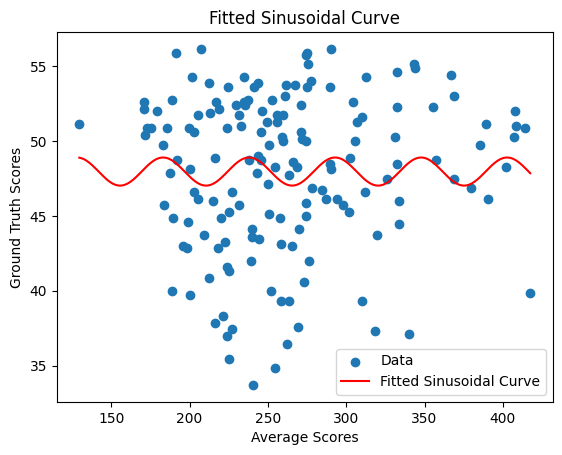

Optimal weights: [0.00000000e+00 0.00000000e+00 6.65451365e-07 0.00000000e+00
 6.41842932e-06 0.00000000e+00 0.00000000e+00 4.98754430e-05
 0.00000000e+00 9.99955034e-01 6.31121398e-06]
Objective function value: 394070.287248046
Obtained scores for each video: [267.49463086 186.63147213 193.59310069 ... 255.90702422 241.69996812
 256.77102292]


In [2]:
import os
import shutil
import subprocess
import csv
import cv2
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from scipy.optimize import minimize, curve_fit
from scipy.stats import spearmanr
import sys
import pickle
import models

# Load FlowNet model
def load_flownet_model(model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    sys.path.append(r'C:\Users\Kaan\Desktop\Thesis\FlowNet')
    network_data = torch.load(model_path, map_location=device)
    model = models.__dict__[network_data['arch']](network_data)
    model.to(device)
    model.eval()
    return model, device

# Compare images using Euclidean distance
def compare_images(img1, img2):
    if img1 is None or img2 is None:
        return 0.0
    if img1.shape != img2.shape:
        img1_resized = cv2.resize(img1, (img2.shape[1], img2.shape[0]))
    else:
        img1_resized = img1
    distances = np.sqrt(np.sum(np.square(img1_resized.astype(np.float32) - img2.astype(np.float32)), axis=2))
    score = np.mean(distances)
    return score

def compute_feature_maps(model, video_frame_path):
    layers = ["conv1", "conv2", "conv3", "conv3_1", "conv4", "conv4_1", "conv5", "conv5_1", "conv6", "conv6_1", "deconv5"]
    feature_maps = []
    for layer in layers:
        layer_path = os.path.join(video_frame_path, 'flow', layer)
        if os.path.exists(layer_path):
            frame_files = os.listdir(layer_path)
            layer_feature_maps = []
            for frame_file in frame_files:
                if frame_file.endswith('.png') or frame_file.endswith('.jpg'):
                    frame_path = os.path.join(layer_path, frame_file)
                    flow_img = cv2.imread(frame_path)
                    
                    # Convert flow_img to grayscale and resize if necessary
                    flow_img_gray = cv2.cvtColor(flow_img, cv2.COLOR_BGR2GRAY)
                    flow_img_gray_resized = cv2.resize(flow_img_gray, (480, 270))
                    
                    # Stack grayscale image to create 6 channels (if needed)
                    flow_img_stacked = np.stack([flow_img_gray_resized] * 6, axis=0)
                    
                    # Convert to tensor and adjust dimensions
                    flow_img_tensor = torch.tensor(flow_img_stacked).unsqueeze(0).float() / 255.0
                    
                    with torch.no_grad():
                        feature_map = model(flow_img_tensor)
                        layer_feature_maps.append(feature_map)
            feature_maps.append(layer_feature_maps)
        else:
            feature_maps.append([])
    return feature_maps

# Compute frequency selectivity
def compute_frequency_selectivity(feature_maps):
    frequency_selectivity = []
    csf_frequencies = np.linspace(6, 8, 20)
    for layer_maps in feature_maps:
        layer_freq_selectivity = []
        for feature_map in layer_maps:
            response = feature_map.detach().cpu().numpy()
            layer_freq_selectivity.append(response)
        frequency_selectivity.append(layer_freq_selectivity)
    return frequency_selectivity

# Compute orientation selectivity
def compute_orientation_selectivity(feature_maps):
    orientation_selectivity = []
    fixed_frequency = 8
    for layer_maps in feature_maps:
        layer_orient_selectivity = []
        for feature_map in layer_maps:
            response = feature_map.detach().cpu().numpy()
            layer_orient_selectivity.append(response)
        orientation_selectivity.append(layer_orient_selectivity)
    return orientation_selectivity

def compute_perceptual_efficacy(frequency_selectivity, orientation_selectivity, layer_weights):
    PE = []
    for layer_idx in range(len(frequency_selectivity)):
        pe_layer = []
        for map_idx in range(len(frequency_selectivity[layer_idx])):
            mu1_normalized = frequency_selectivity[layer_idx][map_idx] / np.max(frequency_selectivity[layer_idx][map_idx])
            mu2_normalized = orientation_selectivity[layer_idx][map_idx] / np.max(orientation_selectivity[layer_idx][map_idx])
            pe_score = layer_weights[layer_idx] * (mu1_normalized * mu2_normalized) / (np.sum(mu1_normalized) * np.sum(mu2_normalized))
            pe_layer.append(pe_score)
        PE.append(pe_layer)
    return PE

# Compute and save scores
def compute_and_save_scores(video_frame_path, output_csv_file):
    layers = ["conv1", "conv2", "conv3", "conv3_1", "conv4", "conv4_1", "conv5", "conv5_1", "conv6", "conv6_1", "deconv5"]
    video_folder = os.path.basename(video_frame_path)
    flow_path = os.path.join(video_frame_path, 'flow')

    try:
        with open(output_csv_file, mode='a', newline='') as file:
            writer = csv.writer(file)
            row = [video_folder]
            for layer in layers:
                layer_path = os.path.join(flow_path, layer)
                if os.path.exists(layer_path):
                    frame_files = os.listdir(layer_path)
                    total_score = 0.0
                    num_comparisons = 0
                    for frame_file in frame_files:
                        if frame_file.endswith('.png'):
                            frame_name = os.path.splitext(frame_file)[0]
                            frame_name_parts = frame_name.split('_')
                            frame_name_parts = [part for part in frame_name_parts if part not in layer.split('_')]
                            frame_name = '_'.join(frame_name_parts)
                            img_file = frame_name + '.jpg'
                            frame_path = os.path.join(layer_path, frame_file)
                            orig_img_path = os.path.join(video_frame_path, img_file)
                            if os.path.exists(orig_img_path):
                                orig_img = cv2.imread(orig_img_path)
                                flow_img = cv2.imread(frame_path)
                                score = compare_images(orig_img, flow_img)
                                total_score += score
                                num_comparisons += 1
                    if num_comparisons > 0:
                        average_score = total_score / num_comparisons
                        row.append(average_score)
                    else:
                        row.append(None)
                else:
                    row.append(None)
            writer.writerow(row)
            print(row)
    except Exception as e:
        print("An error occurred:", e)

# Save checkpoint
def save_checkpoint(checkpoint_file, all_pe_scores, processed_folders):
    with open(checkpoint_file, 'wb') as f:
        pickle.dump({'all_pe_scores': all_pe_scores, 'processed_folders': processed_folders}, f)

# Load checkpoint
def load_checkpoint(checkpoint_file):
    if os.path.exists(checkpoint_file):
        with open(checkpoint_file, 'rb') as f:
            checkpoint = pickle.load(f)
        return checkpoint['all_pe_scores'], checkpoint['processed_folders']
    else:
        return [], []

def run_videos_one_by_one(frames_directory, script_path, model_path, output_csv_file, checkpoint_file, video_limit):
    if not os.path.exists(output_csv_file):
        with open(output_csv_file, mode='w', newline='') as file:
            writer = csv.writer(file)
            layers = ["conv1", "conv2", "conv3", "conv3_1", "conv4", "conv4_1", "conv5", "conv5_1", "conv6", "conv6_1", "deconv5"]
            header = ['Video Name']
            for layer in layers:
                header.append(f'{layer} Flow Score (Euclidean)')
            writer.writerow(header)

    folder_names = sorted(os.listdir(frames_directory))
    model, device = load_flownet_model(model_path)

    all_pe_scores, processed_folders = load_checkpoint(checkpoint_file)

    # Filter unprocessed folders
    unprocessed_folders = [folder_name for folder_name in folder_names if folder_name not in processed_folders]

    # Load ground truth data
    ground_truth_file_path = r"C:\Users\Kaan\Desktop\Thesis\k150kb_scores.csv"
    gt_df = pd.read_csv(ground_truth_file_path)
    gt_df['video_name'] = gt_df['video_name'].str.replace('.mp4', '')
    ground_truth_scores = gt_df['mos'].tolist()
    ground_truth_scores = [(mos / 7) * 100 for mos in ground_truth_scores]
    
    # Limit the number of folders to process based on the smaller of video_limit and the number of ground truth scores
    video_limit = min(video_limit, len(ground_truth_scores))
    folders_to_process = unprocessed_folders[:video_limit]

    # Define layer weights (initially equal weights, will be optimized)
    layer_weights = {
                "conv1": 1.0, "conv2": 1.0, "conv3": 1.0, "conv3_1": 1.0, "conv4": 1.0, "conv4_1": 1.0, "conv5": 1.0,
        "conv5_1": 1.0, "conv6": 1.0, "conv6_1": 1.0, "deconv5": 1.0
    }
    layer_weights = [layer_weights[layer] for layer in layer_weights]

    for folder_name in folders_to_process:
        folder_path = os.path.join(frames_directory, folder_name)
        if os.path.isdir(folder_path):
            flow_folder_path = os.path.join(folder_path, 'flow')
            if os.path.exists(flow_folder_path):
                shutil.rmtree(flow_folder_path)

            command = ["python", script_path, folder_path, model_path, "--output-value", "vis"]
            try:
                result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
                print("Processed video:", folder_path)
                print("Remaining videos:", len(folders_to_process) - folders_to_process.index(folder_name))
                compute_and_save_scores(folder_path, output_csv_file)
                feature_maps = compute_feature_maps(model, folder_path)
                frequency_selectivity = compute_frequency_selectivity(feature_maps)
                orientation_selectivity = compute_orientation_selectivity(feature_maps)
                pe_scores = compute_perceptual_efficacy(frequency_selectivity, orientation_selectivity, layer_weights)
                all_pe_scores.append((folder_name, np.mean(pe_scores)))
                processed_folders.append(folder_name)
                save_checkpoint(checkpoint_file, all_pe_scores, processed_folders)
            except Exception as e:
                print(f"Error processing video {folder_path}: {e}")

            if os.path.exists(flow_folder_path):
                shutil.rmtree(flow_folder_path)
        else:
            print(f"Folder not found: {folder_path}")

    sorted_pe_scores = sorted(all_pe_scores, key=lambda x: x[1], reverse=True)
    top_10_percent = int(len(sorted_pe_scores) * 0.10)  # Adjusted to top 10%
    top_scores = sorted_pe_scores[:top_10_percent]

    # Extract the folder names of the top 10% videos
    top_video_names = [item[0] for item in top_scores]

    # Filter the scores CSV to include only the top 10% videos
    df_scores = pd.read_csv(output_csv_file)
    df_scores = df_scores[df_scores['Video Name'].isin(top_video_names)]
    average_scores = df_scores.iloc[:, 1:].mean(axis=1)

    ground_truth_scores = gt_df[gt_df['video_name'].isin(top_video_names)]['mos']
    ground_truth_scores = [(mos / 7) * 100 for mos in ground_truth_scores]
    ground_truth_scores = np.array(ground_truth_scores)

    spearman_corr, _ = spearmanr(ground_truth_scores, average_scores)
    print(f'Spearman correlation: {spearman_corr:.3f}')

    def sinusoidal(x, a, b, c, d):
        return a * np.sin(b * x + c) + d

    sin_params, _ = curve_fit(sinusoidal, average_scores, ground_truth_scores, p0=[50, 0.1, 0, 50])
    plt.scatter(average_scores, ground_truth_scores, label='Data')
    x_fit = np.linspace(min(average_scores), max(average_scores), 500)
    y_fit = sinusoidal(x_fit, *sin_params)
    plt.plot(x_fit, y_fit, color='red', label='Fitted Sinusoidal Curve')
    plt.xlabel('Average Scores')
    plt.ylabel('Ground Truth Scores')
    plt.title('Fitted Sinusoidal Curve')
    plt.legend()
    plt.show()

    # Additional code for weight optimization and calculating obtained scores
    matrix_df = pd.read_csv(output_csv_file)
    scores_df = pd.read_csv(ground_truth_file_path)
    scores_df['video_name'] = scores_df['video_name'].str.replace('.mp4', '')

    # Sort the matrix by the first column (video names)
    matrix_df.sort_values(by=matrix_df.columns[0], inplace=True)

    # Ensure the scores are aligned with the sorted video names
    scores_df.set_index('video_name', inplace=True)
    sorted_scores_df = scores_df.loc[matrix_df[matrix_df.columns[0]]].reset_index()

    # Extract the sorted scores and distance matrix
    sorted_scores = sorted_scores_df.iloc[:, 1].values
    video_names = matrix_df[matrix_df.columns[0]].values
    d = matrix_df.drop(columns=matrix_df.columns[0]).values

    # Objective function
    def objective(w, d, scores):
        return np.sum(np.sqrt((np.dot(d, w) - scores) ** 2))

    def constraint_sum_to_one(w):
        return np.sum(w) - 1

    N = d.shape[1]

    # Initial weights
    w0 = np.random.rand(N)

    # Bounds for weights
    bounds = [(0, 1) for _ in range(N)]

    # Constraint dictionary: sum of weights must equal 1
    con = {'type': 'eq', 'fun': constraint_sum_to_one}

    result = minimize(objective, w0, args=(d, sorted_scores), bounds=bounds, constraints=con)

    print("Optimal weights:", result.x)
    print("Objective function value:", result.fun)

    # Calculate the obtained scores using the optimal weights
    obtained_scores = np.dot(d, result.x)

    print("Obtained scores for each video:", obtained_scores)

    output_df = pd.DataFrame({
        'Video Name': video_names,
        'Obtained Score': obtained_scores
    })
    output_df.to_csv('obtained_scores.csv', index=False)


# Define your paths and run the main function
frames_directory = r'C:\Users\Kaan\Desktop\Thesis\k150kb_frames'
script_path = r'C:\Users\Kaan\Desktop\Thesis\FlowNet\run_inference.py'
model_path = r'C:\Users\Kaan\Desktop\Thesis\flownets_EPE1.951.pth.tar'
output_csv_file = r"C:\Users\Kaan\Desktop\Thesis\scores_flow_v3.csv"
checkpoint_file = r"C:\Users\Kaan\Desktop\Thesis\checkpoint_videos3.pkl"
video_limit = 1567

run_videos_one_by_one(frames_directory, script_path, model_path, output_csv_file, checkpoint_file, video_limit)


c:\Users\Kaan\Desktop\Thesis\FlowNet\models\util.py:10: ImportWarning: failed to load custom correlation modulewhich is needed for FlowNetC
  warnings.warn("failed to load custom correlation module"


cuda
Processed video: C:\Users\Kaan\Desktop\Thesis\k150kb_frames\orig_9825112745_540_5s
Remaining videos: 7
['orig_9825112745_540_5s', 20094.570794270832, 20081.467486979167, 20078.478294270833, 20077.925950520832, 20077.8262109375, 20078.432565104165, 20081.443802083333, 20081.963333333333, 20105.7109765625, 20089.674166666668, 20078.3264453125]
Processed video: C:\Users\Kaan\Desktop\Thesis\k150kb_frames\orig_9839687555_540_5s
Remaining videos: 6
['orig_9839687555_540_5s', 14891.703662437081, 14886.885303062081, 14885.711396287752, 14885.696944473573, 14885.292024958053, 14886.066006449246, 14887.415497850252, 14890.475323773071, 14909.615522755872, 14894.747024433726, 14885.310664848994]
Processed video: C:\Users\Kaan\Desktop\Thesis\k150kb_frames\orig_9868456496_540_5s
Remaining videos: 5
['orig_9868456496_540_5s', 17308.319091796875, 17309.090405273437, 17304.333748372395, 17301.157104492188, 17301.18527018229, 17302.103580729166, 17303.50157063802, 17305.571915690103, 17321.0897542

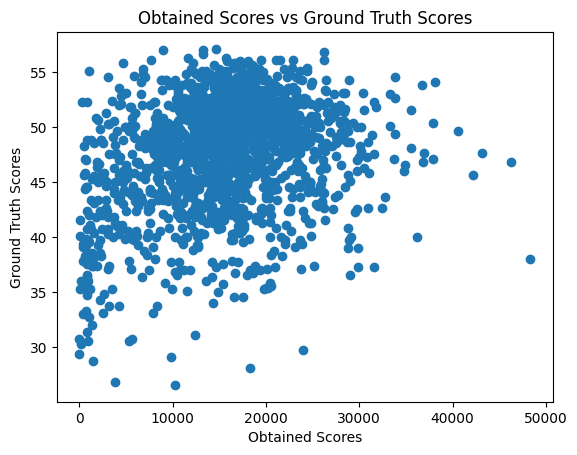

Error fitting curve: name 'curve_fit' is not defined


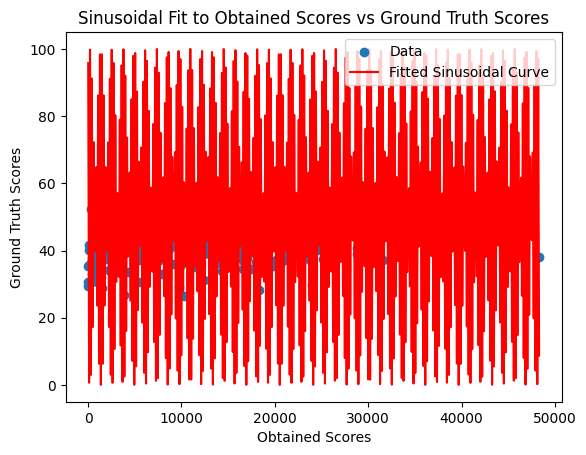

In [1]:
import os
import shutil
import subprocess
import csv
import cv2
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import spearmanr
import sys
import pickle
import models

def load_flownet_model(model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    sys.path.append(r'C:\Users\Kaan\Desktop\Thesis\FlowNet')
    
    network_data = torch.load(model_path, map_location=device, weights_only=True)
    
    model = models.__dict__[network_data['arch']](network_data)
    model.to(device)
    model.eval()
    print(device)
    return model, device

def compute_feature_maps(model, video_frame_path):
    layers = ["conv1", "conv2", "conv3", "conv3_1", "conv4", "conv4_1", "conv5", "conv5_1", "conv6", "conv6_1", "deconv5"]
    feature_maps = []
    
    device = next(model.parameters()).device  
    
    for layer in layers:
        layer_path = os.path.join(video_frame_path, 'flow', layer)
        if os.path.exists(layer_path):
            frame_files = os.listdir(layer_path)
            layer_feature_maps = []
            for frame_file in frame_files:
                if frame_file.endswith('.png') or frame_file.endswith('.jpg'):
                    frame_path = os.path.join(layer_path, frame_file)
                    flow_img = cv2.imread(frame_path)
                    
                    flow_img_gray = cv2.cvtColor(flow_img, cv2.COLOR_BGR2GRAY)
                    flow_img_gray_resized = cv2.resize(flow_img_gray, (480, 270))
                    
                    flow_img_stacked = np.stack([flow_img_gray_resized] * 6, axis=0)
                    
                    flow_img_tensor = torch.tensor(flow_img_stacked).unsqueeze(0).float() / 255.0
                    flow_img_tensor = flow_img_tensor.to(device)
                    
                    with torch.no_grad():
                        feature_map = model(flow_img_tensor)
                        layer_feature_maps.append(feature_map)
            feature_maps.append(layer_feature_maps)
        else:
            feature_maps.append([])
    return feature_maps

def compute_errors(original_frames, feature_maps):
    normalized_errors = []
    for layer_maps in feature_maps:
        layer_errors = []
        for original_frame, intermediate_map in zip(original_frames, layer_maps):
            
            original_frame_gray = cv2.cvtColor(original_frame, cv2.COLOR_BGR2GRAY)
            original_frame_gray_tensor = torch.tensor(original_frame_gray, dtype=torch.float32)

            
            original_frame_tensor = torch.stack([original_frame_gray_tensor, original_frame_gray_tensor], dim=0)

            
            if original_frame_tensor.shape[1:] != intermediate_map.shape[2:]:
                original_frame_tensor = torch.nn.functional.interpolate(
                    original_frame_tensor.unsqueeze(0), size=(intermediate_map.shape[2], intermediate_map.shape[3]), mode='bilinear', align_corners=False).squeeze(0)

           
            original_frame_tensor = original_frame_tensor.to(intermediate_map.device)

            
            difference = original_frame_tensor - intermediate_map.squeeze(0)

            squared_error = torch.sum(difference ** 2)
            C_l, H_l, W_l = intermediate_map.shape[1:]
            normalized_error = squared_error / (C_l * H_l * W_l)
   
            layer_errors.append(normalized_error.item())

        
        if layer_errors:  
            mean_error = np.mean(layer_errors)
        else:
            mean_error = 0  

        normalized_errors.append(mean_error)

    return normalized_errors


def save_checkpoint(checkpoint_file, all_errors, processed_folders):
    with open(checkpoint_file, 'wb') as f:
        pickle.dump({'all_errors': all_errors, 'processed_folders': processed_folders}, f)


def load_checkpoint(checkpoint_file):
    if os.path.exists(checkpoint_file):
        try:
            with open(checkpoint_file, 'rb') as f:
                checkpoint = pickle.load(f)
            # Ensure the keys exist
            all_errors = checkpoint.get('all_errors', [])
            processed_folders = checkpoint.get('processed_folders', [])
            return all_errors, processed_folders
        except Exception as e:
            print(f"Error loading checkpoint: {e}")
            return [], []
    else:
        return [], []

import pandas as pd
import csv

def run_videos_one_by_one(frames_directory, script_path, model_path, output_csv_file, checkpoint_file, video_limit):
    # Initialize the CSV file if it doesn't exist
    if not os.path.exists(output_csv_file):
        with open(output_csv_file, mode='w', newline='') as file:
            writer = csv.writer(file)
            layers = ["conv1", "conv2", "conv3", "conv3_1", "conv4", "conv4_1", "conv5", "conv5_1", "conv6", "conv6_1", "deconv5"]
            header = ['Video Name']
            for layer in layers:
                header.append(f'{layer} Flow Error (Squared)')
            writer.writerow(header)

    folder_names = sorted(os.listdir(frames_directory))
    model, device = load_flownet_model(model_path)

    all_errors, processed_folders = load_checkpoint(checkpoint_file)

    unprocessed_folders = [folder_name for folder_name in folder_names if folder_name not in processed_folders]

    ground_truth_file_path = r"C:\Users\Kaan\Desktop\Thesis\k150kb_scores.csv"
    gt_df = pd.read_csv(ground_truth_file_path)
    gt_df['video_name'] = gt_df['video_name'].str.replace('.mp4', '')
    ground_truth_dict = dict(zip(gt_df['video_name'], gt_df['mos'] * 100 / 7))
    
    video_limit = min(video_limit, len(unprocessed_folders))
    folders_to_process = unprocessed_folders[:video_limit]

    for folder_name in folders_to_process:
        folder_path = os.path.join(frames_directory, folder_name)
        if os.path.isdir(folder_path):
            flow_folder_path = os.path.join(folder_path, 'flow')
            if os.path.exists(flow_folder_path):
                shutil.rmtree(flow_folder_path)

            command = ["python", script_path, folder_path, model_path, "--output-value", "vis"]
            try:
                result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
                print("Processed video:", folder_path)
                print("Remaining videos:", len(folders_to_process) - folders_to_process.index(folder_name))
                
                feature_maps = compute_feature_maps(model, folder_path)
                original_frames = [cv2.imread(os.path.join(folder_path, img_file)) for img_file in sorted(os.listdir(folder_path)) if img_file.endswith('.jpg')]
                errors = compute_errors(original_frames, feature_maps)
                
                with open(output_csv_file, mode='a', newline='') as file:
                    writer = csv.writer(file)
                    row = [folder_name] + errors
                    writer.writerow(row)
                    print(row)

                all_errors.append((folder_name,errors))
                processed_folders.append(folder_name)
                save_checkpoint(checkpoint_file, all_errors, processed_folders)
            except Exception as e:
                print(f"Error processing video {folder_path}: {e}")

            if os.path.exists(flow_folder_path):
                shutil.rmtree(flow_folder_path)
        else:
            print(f"Folder not found: {folder_path}")

    matrix_df = pd.read_csv(output_csv_file)
    matrix_df.drop_duplicates(subset='Video Name', inplace=True)
    matrix_df.sort_values(by='Video Name', inplace=True)

    # Align video names with ground truth scores
    video_names = matrix_df['Video Name'].values
    sorted_scores = [ground_truth_dict[v] for v in video_names if v in ground_truth_dict]

    d = matrix_df.drop(columns='Video Name').values

    def objective(w, d, scores):
        return np.sum(np.sqrt((np.dot(d, w) - scores) ** 2))

    def constraint_sum_to_one(w):
        return np.sum(w) - 1

    N = d.shape[1]

    w0 = np.random.rand(N)

    bounds = [(0, 1) for _ in range(N)]

    con = {'type': 'eq', 'fun': constraint_sum_to_one}

    try:
        result = minimize(objective, w0, args=(d, sorted_scores), bounds=bounds, constraints=con)
        optimal_weights = result.x
        print("Optimal weights:", optimal_weights)
        print("Objective function value:", result.fun)

        obtained_scores = np.dot(d, optimal_weights)
        print("Obtained scores for each video:", obtained_scores)

        output_df = pd.DataFrame({
            'Video Name': video_names,
            'Obtained Score': obtained_scores
        })
        output_df.to_csv('obtained_scores.csv', index=False)
    except Exception as e:
        print(f"Optimization error: {e}")

    spearman_corr, _ = spearmanr(obtained_scores, sorted_scores)
    print(f'Spearman correlation: {spearman_corr:.3f}')

    # Plotting the obtained scores vs ground truth scores
    plt.scatter(obtained_scores, sorted_scores)
    plt.xlabel('Obtained Scores')
    plt.ylabel('Ground Truth Scores')
    plt.title('Obtained Scores vs Ground Truth Scores')
    plt.show()

   
    def sinusoidal(x, a, b, c, d):
        return a * np.sin(b * x + c) + d

    
    try:
        sin_params, _ = curve_fit(sinusoidal, obtained_scores, sorted_scores, p0=[50, 0.1, 0, 50])
    except Exception as e:
        print(f"Error fitting curve: {e}")
        sin_params = [50, 0.1, 0, 50]  

   
    x_fit = np.linspace(min(obtained_scores), max(obtained_scores), 500)
    y_fit = sinusoidal(x_fit, *sin_params)

    plt.scatter(obtained_scores, sorted_scores, label='Data')
    plt.plot(x_fit, y_fit, color='red', label='Fitted Sinusoidal Curve')
    plt.xlabel('Obtained Scores')
    plt.ylabel('Ground Truth Scores')
    plt.title('Sinusoidal Fit to Obtained Scores vs Ground Truth Scores')
    plt.legend()
    plt.show()

frames_directory = r'C:\Users\Kaan\Desktop\Thesis\k150kb_frames'
script_path = r'C:\Users\Kaan\Desktop\Thesis\FlowNet\run_inference.py'
model_path = r'C:\Users\Kaan\Desktop\Thesis\flownets_EPE1.951.pth.tar'
output_csv_file = r"C:\Users\Kaan\Desktop\Thesis\scores_flow_v42.csv"
checkpoint_file = r"C:\Users\Kaan\Desktop\Thesis\checkpoint_videos_testo.pkl"
video_limit = 1567

run_videos_one_by_one(frames_directory, script_path, model_path, output_csv_file, checkpoint_file, video_limit)



In [1]:
import os
import shutil
import subprocess
import csv
import cv2
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import spearmanr
import tempfile
import sys
import pickle
import models
from scipy.optimize import curve_fit

def load_flownet_model(model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    sys.path.append(r'C:\Users\Kaan\Desktop\Thesis\FlowNet')
    
    network_data = torch.load(model_path, map_location=device, weights_only=True)
    
    model = models.__dict__[network_data['arch']](network_data)
    model.to(device)
    model.eval()
    print(device)
    return model, device

def compute_feature_maps(model, video_frame_path):
    layers = ["conv1", "conv2", "conv3", "conv3_1", "conv4", "conv4_1", "conv5", "conv5_1", "conv6", "conv6_1", "deconv5"]
    feature_maps = []
    
    device = next(model.parameters()).device  

    for layer in layers:
        layer_path = os.path.join(video_frame_path, 'flow', layer)
        if os.path.exists(layer_path):
            frame_files = os.listdir(layer_path)
            layer_feature_maps = []
            for frame_file in frame_files:
                if frame_file.endswith('.png') or frame_file.endswith('.jpg'):
                    frame_path = os.path.join(layer_path, frame_file)
                    flow_img = cv2.imread(frame_path)
                    
                    flow_img_gray = cv2.cvtColor(flow_img, cv2.COLOR_BGR2GRAY)
                    flow_img_gray_resized = cv2.resize(flow_img_gray, (480, 270))
                    
                    flow_img_stacked = np.stack([flow_img_gray_resized] * 6, axis=0)
                    
                    flow_img_tensor = torch.tensor(flow_img_stacked).unsqueeze(0).float() / 255.0
                    flow_img_tensor = flow_img_tensor.to(device)
                    
                    with torch.no_grad():
                        feature_map = model(flow_img_tensor)
                        layer_feature_maps.append(feature_map)
            feature_maps.append(layer_feature_maps)
        else:
            feature_maps.append([])
    return feature_maps

def apply_distortion(frame):
    distorted_frame = cv2.medianBlur(frame,15)  
    return distorted_frame

def save_distorted_frames(original_frames):
    """Save distorted frames into a temporary folder."""
    temp_dir = tempfile.mkdtemp()  
    distorted_folder_path = os.path.join(temp_dir, 'distorted_frames')

    os.makedirs(distorted_folder_path, exist_ok=True)

    for i, frame in enumerate(original_frames):
        distorted_frame = apply_distortion(frame) 
        distorted_frame_path = os.path.join(distorted_folder_path, f'{i:04d}.jpg')  
        cv2.imwrite(distorted_frame_path, distorted_frame)

    return distorted_folder_path

def compute_errors(original_feature_maps, distorted_feature_maps):
    normalized_errors = []
    
    for original_maps, distorted_maps in zip(original_feature_maps, distorted_feature_maps):
        layer_errors = []
        for original_map, distorted_map in zip(original_maps, distorted_maps):
            
            if original_map.shape[2:] != distorted_map.shape[2:]:
                distorted_map = torch.nn.functional.interpolate(
                    distorted_map, size=(original_map.shape[2], original_map.shape[3]), mode='bilinear', align_corners=False)
            
            difference = original_map - distorted_map
            
            squared_error = torch.sum(difference ** 2)
            C_l, H_l, W_l = original_map.shape[1:]
            normalized_error = squared_error / (C_l * H_l * W_l)
            
            layer_errors.append(normalized_error.item())
        
        mean_error = np.mean(layer_errors) if layer_errors else 0
        normalized_errors.append(mean_error)
    
    return normalized_errors

def save_checkpoint(checkpoint_file, all_errors, processed_folders):
    with open(checkpoint_file, 'wb') as f:
        pickle.dump({'all_errors': all_errors, 'processed_folders': processed_folders}, f)

def load_checkpoint(checkpoint_file):
    if os.path.exists(checkpoint_file):
        try:
            with open(checkpoint_file, 'rb') as f:
                checkpoint = pickle.load(f)

            all_errors = checkpoint.get('all_errors', [])
            processed_folders = checkpoint.get('processed_folders', [])
            return all_errors, processed_folders
        except Exception as e:
            print(f"Error loading checkpoint: {e}")
            return [], []
    else:
        return [], []

def run_videos_one_by_one(frames_directory, script_path, model_path, output_csv_file, checkpoint_file, video_limit):

    if not os.path.exists(output_csv_file):
        with open(output_csv_file, mode='w', newline='') as file:
            writer = csv.writer(file)
            layers = ["conv1", "conv2", "conv3", "conv3_1", "conv4", "conv4_1", "conv5", "conv5_1", "conv6", "conv6_1", "deconv5"]
            header = ['Video Name']
            for layer in layers:
                header.append(f'{layer} Flow Error (Squared)')
            writer.writerow(header)

    folder_names = sorted(os.listdir(frames_directory))
    model, device = load_flownet_model(model_path)

    all_errors, processed_folders = load_checkpoint(checkpoint_file)

    unprocessed_folders = [folder_name for folder_name in folder_names if folder_name not in processed_folders]

    video_limit = min(video_limit, len(unprocessed_folders))
    folders_to_process = unprocessed_folders[:video_limit]

    for folder_name in folders_to_process:
        folder_path = os.path.join(frames_directory, folder_name)
        if os.path.isdir(folder_path):
            flow_folder_path = os.path.join(folder_path, 'flow')
            if os.path.exists(flow_folder_path):
                shutil.rmtree(flow_folder_path)

            try:

                command = ["python", script_path, folder_path, model_path, "--output-value", "vis"]
                result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
                print("Processed original video:", folder_path)

                original_frames = [cv2.imread(os.path.join(folder_path, img_file)) for img_file in sorted(os.listdir(folder_path)) if img_file.endswith('.jpg')]
                original_feature_maps = compute_feature_maps(model, folder_path)

                distorted_folder_path = save_distorted_frames(original_frames)
                command = ["python", script_path, distorted_folder_path, model_path, "--output-value", "vis"]
                result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
                print("Processed distorted video:", distorted_folder_path)

                distorted_feature_maps = compute_feature_maps(model, distorted_folder_path)

                errors = compute_errors(original_feature_maps, distorted_feature_maps)
                
                with open(output_csv_file, mode='a', newline='') as file:
                    writer = csv.writer(file)
                    row = [folder_name] + errors
                    writer.writerow(row)
                    print(row)

                all_errors.append((folder_name, errors))
                processed_folders.append(folder_name)
                save_checkpoint(checkpoint_file, all_errors, processed_folders)

                shutil.rmtree(distorted_folder_path)
            except Exception as e:
                print(f"Error processing video {folder_path}: {e}")

            if os.path.exists(flow_folder_path):
                shutil.rmtree(flow_folder_path)
        else:
            print(f"Folder not found: {folder_path}")

    ground_truth_file_path = r"C:\Users\Kaan\Desktop\Thesis\k150kb_scores.csv"
    gt_df = pd.read_csv(ground_truth_file_path)
    gt_df['video_name'] = gt_df['video_name'].str.replace('.mp4', '')
    ground_truth_dict = dict(zip(gt_df['video_name'], gt_df['mos'] * 100 / 7))
    
    matrix_df = pd.read_csv(output_csv_file)
    matrix_df.drop_duplicates(subset='Video Name', inplace=True)
    matrix_df.sort_values(by='Video Name', inplace=True)

    video_names = matrix_df['Video Name'].values
    sorted_scores = [ground_truth_dict[v] for v in video_names if v in ground_truth_dict]

    d = matrix_df.drop(columns='Video Name').values

    def objective(w, d, scores):
        return np.sum(np.sqrt((np.dot(d, w) - scores) ** 2))

    def constraint_sum_to_one(w):
        return np.sum(w) - 1

    N = d.shape[1]

    w0 = np.random.rand(N)

    bounds = [(0, 1) for _ in range(N)]

    con = {'type': 'eq', 'fun': constraint_sum_to_one}

    try:
        result = minimize(objective, w0, args=(d, sorted_scores), bounds=bounds, constraints=con)
        optimal_weights = result.x
        print("Optimal weights:", optimal_weights)
        print("Objective function value:", result.fun)

        obtained_scores = np.dot(d, optimal_weights)
        print("Obtained scores for each video:", obtained_scores)

        output_df = pd.DataFrame({
            'Video Name': video_names,
            'Obtained Score': obtained_scores
        })
        output_df.to_csv('obtained_scores.csv', index=False)
    except Exception as e:
        print(f"Optimization error: {e}")

    spearman_corr, _ = spearmanr(obtained_scores, sorted_scores)
    print(f'Spearman correlation: {spearman_corr:.3f}')

    plt.scatter(obtained_scores, sorted_scores)
    plt.xlabel('Obtained Scores')
    plt.ylabel('Ground Truth Scores')
    plt.title('Obtained Scores vs Ground Truth Scores')
    plt.show()

    # Fitting sinusoidal curve
    def sinusoidal(x, a, b, c, d):
        return a * np.sin(b * x + c) + d

    try:
        sin_params, _ = curve_fit(sinusoidal, obtained_scores, sorted_scores, p0=[50, 0.1, 0, 50])
    except Exception as e:
        print(f"Error fitting curve: {e}")
        sin_params = [50, 0.1, 0, 50]  

    x_fit = np.linspace(min(obtained_scores), max(obtained_scores), 500)
    y_fit = sinusoidal(x_fit, *sin_params)

    plt.scatter(obtained_scores, sorted_scores, label='Data')
    plt.plot(x_fit, y_fit, color='red', label='Fitted Sinusoidal Curve')
    plt.xlabel('Obtained Scores')
    plt.ylabel('Ground Truth Scores')
    plt.title('Sinusoidal Fit to Obtained Scores vs Ground Truth Scores')
    plt.legend()
    plt.show()

frames_directory = r'C:\Users\Kaan\Desktop\Thesis\k150kb_frames'
script_path = r'C:\Users\Kaan\Desktop\Thesis\FlowNet\run_inference.py'
model_path = r'C:\Users\Kaan\Desktop\Thesis\flownets_EPE1.951.pth.tar'
output_csv_file = r"C:\Users\Kaan\Desktop\Thesis\scores_flow_distorted.csv"
checkpoint_file = r"C:\Users\Kaan\Desktop\Thesis\checkpoint_videos_distorted.pkl"
video_limit = 1567

run_videos_one_by_one(frames_directory, script_path, model_path, output_csv_file, checkpoint_file, video_limit)


c:\Users\Kaan\Desktop\Thesis\FlowNet\models\util.py:10: ImportWarning: failed to load custom correlation modulewhich is needed for FlowNetC
  warnings.warn("failed to load custom correlation module"


cuda
Processed original video: C:\Users\Kaan\Desktop\Thesis\k150kb_frames\orig_11241102906_540_5s
Processed distorted video: C:\Users\Kaan\AppData\Local\Temp\tmpq3c0rb82\distorted_frames
['orig_11241102906_540_5s', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


# USING VGG16 Model To Process Video Frames and Compute Quality Scores


Device: cuda


C:\Users\Kaan\AppData\Local\Temp\ipykernel_6104\3950394296.py:254: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k * (x - x0)))
C:\Users\Kaan\AppData\Local\Temp\ipykernel_6104\3950394296.py:263: OptimizeWarning: Covariance of the parameters could not be estimated
  log_params_ssim, _ = curve_fit(logistic, top_ssim_scores, np.array(ground_truth_scores)[all_indices], p0=[50, 0.1, 0], maxfev=2000)


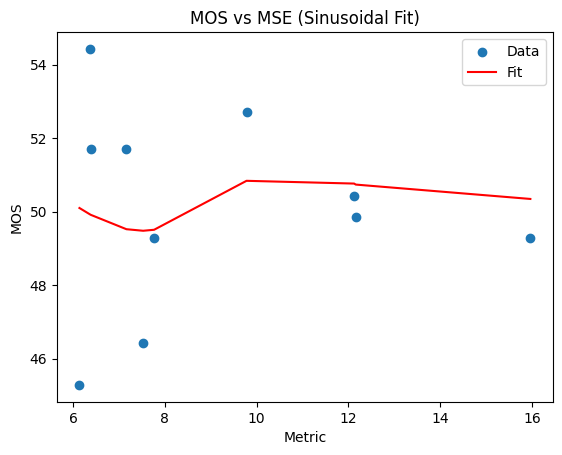

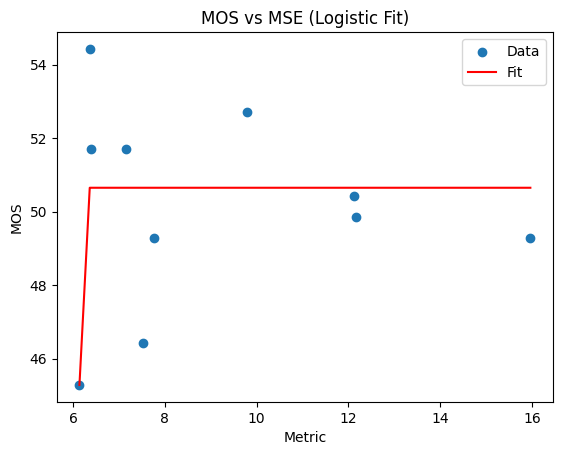

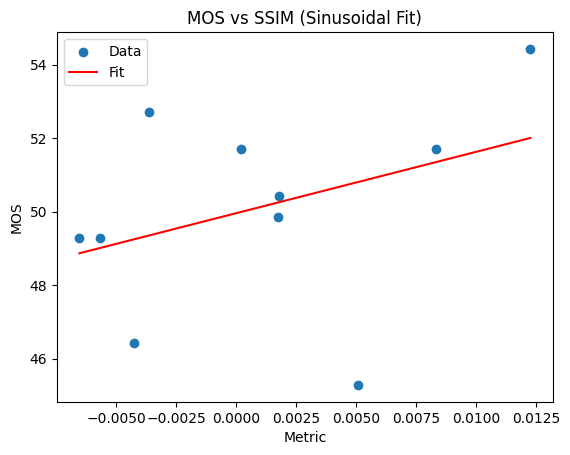

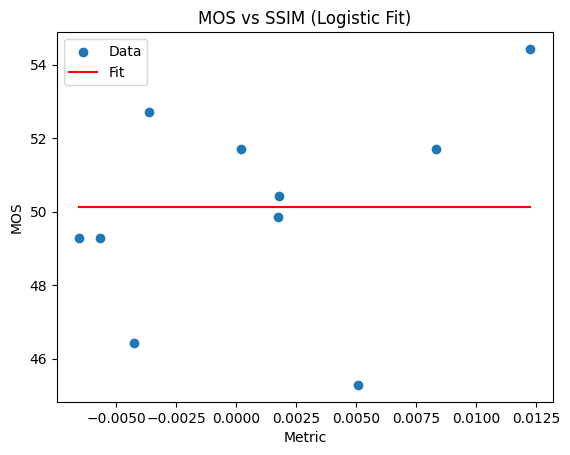

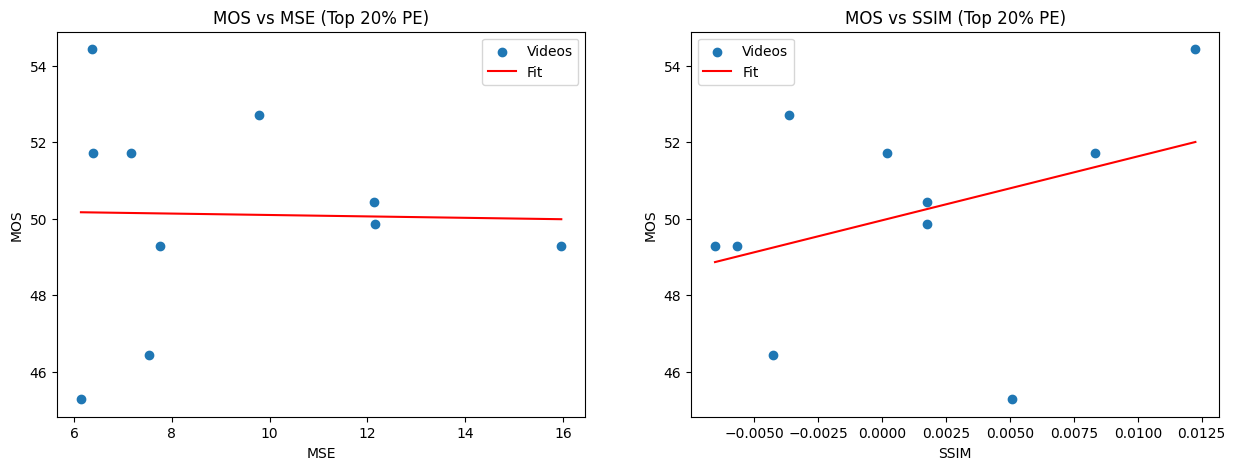

In [24]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import vgg16
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import mean_squared_error, structural_similarity as ssim
from scipy.ndimage import zoom
from scipy.stats import spearmanr
from scipy.optimize import curve_fit
import pickle
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
frames_directory = r'C:\Users\Kaan\Desktop\Thesis\k150kb_frames'
ground_truth_file_path = r"C:\Users\Kaan\Desktop\Thesis\k150kb_scores.csv"
checkpoint_path = r"C:\Users\Kaan\Desktop\Thesis\checkpoint_VGG.pkl"

gt_df = pd.read_csv(ground_truth_file_path)
gt_df['video_name'] = gt_df['video_name'].str.replace('.mp4', '')
video_names = gt_df['video_name'].tolist()
ground_truth_scores = gt_df['mos'].tolist()
ground_truth_scores = [(mos / 7) * 100 for mos in ground_truth_scores]

model = vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features.to(device)
model.eval()

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = preprocess(image).unsqueeze(0).to(device)
    return image

def get_feature_maps(image, model):
    x = image
    feature_maps = []
    for layer in model:
        x = layer(x)
        feature_maps.append(x)
    return feature_maps

def compute_csf(f):
    return 2.6 * (0.0192 + 0.114 * f) * np.exp(- (0.114 * f) ** 1.1)

def generate_sinusoidal_grating(size, frequency, orientation=0):
    x = np.linspace(0, 2 * np.pi * frequency, size)
    y = np.linspace(0, 2 * np.pi * frequency, size)
    X, Y = np.meshgrid(x, y)
    grating = np.sin(X * np.cos(orientation) + Y * np.sin(orientation))
    return grating

def resize_grating(grating, target_shape):
    zoom_factors = [target_shape[0] / grating.shape[0], target_shape[1] / grating.shape[1]]
    resized_grating = zoom(grating, zoom_factors)
    return resized_grating

def compute_frequency_selectivity(feature_maps):
    frequency_selectivity = []
    csf_frequencies = np.linspace(6, 8, 20)
    
    for feature_map in feature_maps:
        target_shape = feature_map.shape[-2:]
        fm_np = feature_map.squeeze(0).detach().cpu().numpy()
        freq_responses = []
        
        for f in csf_frequencies:
            grating = generate_sinusoidal_grating(224, f)
            grating = resize_grating(grating, target_shape)
            response = np.mean(np.abs(fm_np * grating))
            freq_responses.append(response)
        
        freq_responses = np.array(freq_responses)
        csf_weights = compute_csf(csf_frequencies)  
        
        mu1 = np.sum(csf_weights * np.abs(np.gradient(freq_responses)))  
        frequency_selectivity.append(mu1)
    
    return frequency_selectivity

def compute_orientation_selectivity(feature_maps):
    orientation_selectivity = []
    fixed_frequency = 8  
    
    for feature_map in feature_maps:
        target_shape = feature_map.shape[-2:]  
        fm_np = feature_map.squeeze(0).detach().cpu().numpy()
        orient_responses = []
        
        for theta in np.linspace(-np.pi / 2, np.pi / 2, 18): 
            grating = generate_sinusoidal_grating(224, fixed_frequency, theta)
            grating = resize_grating(grating, target_shape)
            response = np.mean(np.abs(fm_np * grating))
            orient_responses.append(response)
        
        orient_responses = np.array(orient_responses)
        a_hat = np.max(orient_responses)
        mu2 = np.sum((orient_responses - a_hat) ** 2)
        orientation_selectivity.append(mu2)
    
    return orientation_selectivity

def compute_perceptual_efficacy(frequency_selectivity, orientation_selectivity):
    mu1_normalized = frequency_selectivity / np.max(frequency_selectivity)
    mu2_normalized = orientation_selectivity / np.max(orientation_selectivity)
    PE = (mu1_normalized * mu2_normalized) / (np.sum(mu1_normalized) * np.sum(mu2_normalized))
    return PE

def compute_mse(image, feature_map):
    image_np = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
    fm_np = feature_map.squeeze(0).detach().cpu().numpy()  
    fm_resized = zoom(fm_np, (image_np.shape[0] / fm_np.shape[0], image_np.shape[1] / fm_np.shape[1], 1))
    
    if fm_resized.shape != image_np.shape:
        fm_resized = fm_resized[:, :, :image_np.shape[2]]  

    return mean_squared_error(image_np, fm_resized)

def compute_ssim(image, feature_map, win_size=3):
    image_np = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
    fm_np = feature_map.squeeze(0).detach().cpu().numpy() 
    fm_resized = zoom(fm_np, (image_np.shape[0] / fm_np.shape[0], image_np.shape[1] / fm_np.shape[1], 1))
    
    if fm_resized.shape != image_np.shape:
        fm_resized = fm_resized[:, :, :image_np.shape[2]]  
    
    return ssim(image_np, fm_resized, win_size=win_size, channel_axis=-1, data_range=image_np.max() - image_np.min())


video_limit = 10
video_names = video_names[:video_limit]
ground_truth_scores = ground_truth_scores[:video_limit]

all_frequency_selectivity = []
all_orientation_selectivity = []
all_pe_scores = []
all_mse_scores = []
all_ssim_scores = []

start_idx = 0
if os.path.exists(checkpoint_path):
    with open(checkpoint_path, 'rb') as f:
        checkpoint = pickle.load(f)
        start_idx = checkpoint['start_idx']
        all_frequency_selectivity = checkpoint['all_frequency_selectivity']
        all_orientation_selectivity = checkpoint['all_orientation_selectivity']
        all_pe_scores = checkpoint['all_pe_scores']
        all_mse_scores = checkpoint['video_mse_scores']
        all_ssim_scores = checkpoint['video_ssim_scores']

for idx, video_name in enumerate(video_names[start_idx:], start=start_idx):
    video_folder = os.path.join(frames_directory, video_name)
    frame_files = sorted([f for f in os.listdir(video_folder) if f.startswith('frame_') and f.endswith('.jpg')])

    video_freq_sel = []
    video_orient_sel = []
    video_pe_scores = []
    video_mse_scores = []
    video_ssim_scores = []
    frame_mse_scores = []
    frame_ssim_scores = []

    print(f'Processing video {idx + 1}/{len(video_names)}: {video_name}')

    for j, frame_file in enumerate(frame_files):
        frame_path = os.path.join(video_folder, frame_file)
        frame = load_image(frame_path)
        feature_maps = get_feature_maps(frame, model)
        
        freq_sel = compute_frequency_selectivity(feature_maps)
        orient_sel = compute_orientation_selectivity(feature_maps)
        pe_scores = compute_perceptual_efficacy(freq_sel, orient_sel)
        
        video_freq_sel.append(freq_sel)
        video_orient_sel.append(orient_sel)
        video_pe_scores.append(pe_scores)

        mse_scores = []
        ssim_scores = []
        print(f'  Frame {j + 1}/{len(frame_files)}')
        for k, fm in enumerate(feature_maps):
            mse_score = compute_mse(frame, fm)
            ssim_score = compute_ssim(frame, fm)

            mse_scores.append(mse_score)
            ssim_scores.append(ssim_score)

        
        
        frame_mse_scores.append(np.mean(mse_scores))
        frame_ssim_scores.append(np.mean(ssim_scores))
    
    video_mse_scores.append(np.mean(frame_mse_scores))
    video_ssim_scores.append(np.mean(frame_ssim_scores))

    avg_freq_sel = np.mean(video_freq_sel)
    avg_orient_sel = np.mean(video_orient_sel)
    avg_pe_score = np.mean(video_pe_scores)

    all_frequency_selectivity.append(avg_freq_sel)
    all_orientation_selectivity.append(avg_orient_sel)
    all_pe_scores.append(avg_pe_score)
    
    all_mse_scores.append(video_mse_scores)
    all_ssim_scores.append(video_ssim_scores)
    
    if (idx + 1) % 5 == 0:
        with open(checkpoint_path, 'wb') as f:
            checkpoint = {
                'start_idx': idx + 1,
                'all_frequency_selectivity': all_frequency_selectivity,
                'all_orientation_selectivity': all_orientation_selectivity,
                'all_pe_scores': all_pe_scores,
                'video_mse_scores': all_mse_scores,
                'video_ssim_scores': all_ssim_scores
            }
            pickle.dump(checkpoint, f)
    print(f"pe_score number: {len(all_pe_scores)}, mse number: {len(all_mse_scores)}, ssim number: {len(all_ssim_scores)}")

all_frequency_selectivity = np.array(all_frequency_selectivity)
all_orientation_selectivity = np.array(all_orientation_selectivity)
all_pe_scores = np.array(all_pe_scores)
all_mse_scores = np.array(all_mse_scores)
all_ssim_scores = np.array(all_ssim_scores)

if len(all_pe_scores) == 0 or len(all_mse_scores) == 0 or len(all_ssim_scores) == 0:
    raise ValueError("The input arrays must have at least one element.")

if len(all_pe_scores) != len(all_mse_scores) or len(all_pe_scores) != len(all_ssim_scores):
    print(f"pe_score: {len(all_pe_scores)}, mse: {len(all_mse_scores)}, ssim: {len(all_ssim_scores)}")
    raise ValueError("The lengths of all_pe_scores, all_mse_scores, and all_ssim_scores must match.")
    
all_indices = np.arange(len(all_pe_scores))

top_mse_scores = np.array(all_mse_scores)[all_indices]
top_ssim_scores = np.array(all_ssim_scores)[all_indices]

correlation_pe_mse_top, _ = spearmanr(top_mse_scores, np.array(all_pe_scores)[all_indices])
correlation_pe_ssim_top, _ = spearmanr(top_ssim_scores, np.array(all_pe_scores)[all_indices])

def sinusoidal(x, a, b, c, d):
    return a * np.sin(b * x + c) + d

def logistic(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

top_mse_scores=top_mse_scores.flatten()
top_ssim_scores=top_ssim_scores.flatten()

sin_params_mse, _ = curve_fit(sinusoidal, top_mse_scores, np.array(ground_truth_scores)[all_indices], p0=[50, 0.1, 0, 50])
log_params_mse, _ = curve_fit(logistic, top_mse_scores, np.array(ground_truth_scores)[all_indices], p0=[50, 0.1, 0], maxfev=2000)

sin_params_ssim, _ = curve_fit(sinusoidal, top_ssim_scores, np.array(ground_truth_scores)[all_indices], p0=[50, 0.1, 0, 50])
log_params_ssim, _ = curve_fit(logistic, top_ssim_scores, np.array(ground_truth_scores)[all_indices], p0=[50, 0.1, 0], maxfev=2000)

def plot_with_curve(x_data, y_data, curve_params, curve_func, title):
    plt.scatter(x_data, y_data, label='Data')
    plt.plot(np.unique(x_data), curve_func(np.unique(x_data), *curve_params), color='red', label='Fit')
    plt.title(title)
    plt.xlabel('Metric')
    plt.ylabel('MOS')
    plt.legend()
    plt.show()

plot_with_curve(top_mse_scores, np.array(ground_truth_scores)[all_indices], sin_params_mse, sinusoidal, 'MOS vs MSE (Sinusoidal Fit)')
plot_with_curve(top_mse_scores, np.array(ground_truth_scores)[all_indices], log_params_mse, logistic, 'MOS vs MSE (Logistic Fit)')

plot_with_curve(top_ssim_scores, np.array(ground_truth_scores)[all_indices], sin_params_ssim, sinusoidal, 'MOS vs SSIM (Sinusoidal Fit)')
plot_with_curve(top_ssim_scores, np.array(ground_truth_scores)[all_indices], log_params_ssim, logistic, 'MOS vs SSIM (Logistic Fit)')


def plot_results(mse_scores, ssim_scores, mos_values):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.scatter(mse_scores, mos_values, label='Videos')
    ax1.plot(np.unique(mse_scores), np.poly1d(np.polyfit(mse_scores, mos_values, 1))(np.unique(mse_scores)), color='red', label='Fit')
    ax1.set_title('MOS vs MSE (Top 20% PE)')
    ax1.set_xlabel('MSE')
    ax1.set_ylabel('MOS')
    ax1.legend()

    ax2.scatter(ssim_scores, mos_values, label='Videos')
    ax2.plot(np.unique(ssim_scores), np.poly1d(np.polyfit(ssim_scores, mos_values, 1))(np.unique(ssim_scores)), color='red', label='Fit')
    ax2.set_title('MOS vs SSIM (Top 20% PE)')
    ax2.set_xlabel('SSIM')
    ax2.set_ylabel('MOS')
    ax2.legend()

    plt.show()

plot_results(top_mse_scores, top_ssim_scores, np.array(ground_truth_scores)[all_indices])



### Kde plotting try 
### kde=True